In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# VAE Architecture Definition
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # Mean for the latent distribution
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance for the latent distribution

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_subclasses\functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


ModuleNotFoundError: No module named 'numpy'

In [2]:
# VAE Loss Function
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction Loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL Divergence Loss
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div


In [3]:
# Data Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Model, Optimizer
latent_dim = 20
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the VAE
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 784)  # Flatten images
        optimizer.zero_grad()
        recon_data, mu, log_var = model(data)
        loss = vae_loss(recon_data, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.16MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.58MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 155.1559
Epoch 2, Loss: 119.0721
Epoch 3, Loss: 113.5528
Epoch 4, Loss: 111.1834
Epoch 5, Loss: 109.7244
Epoch 6, Loss: 108.7915
Epoch 7, Loss: 108.1502
Epoch 8, Loss: 107.6148
Epoch 9, Loss: 107.2064
Epoch 10, Loss: 106.8442


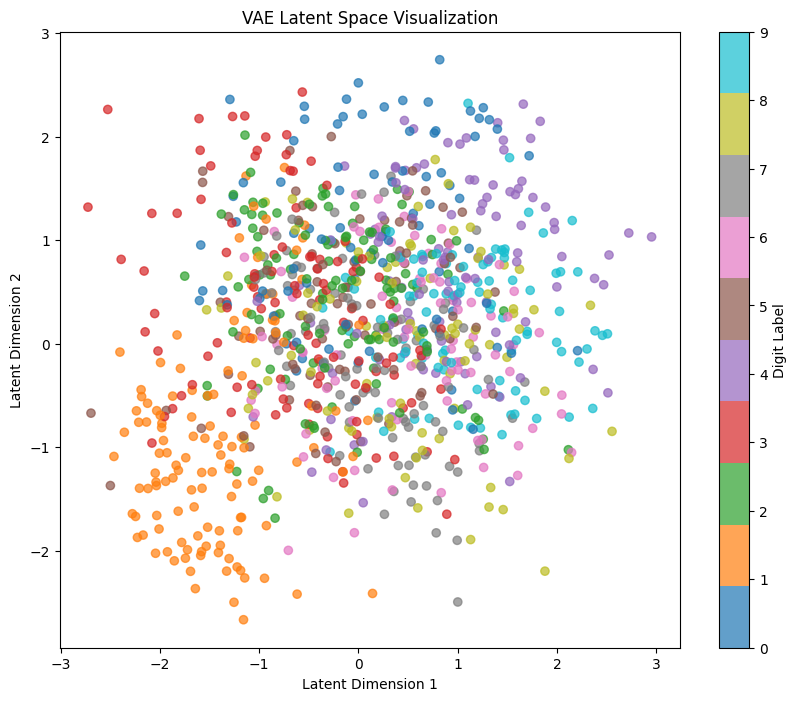

In [4]:
import numpy as np

# Extract latent variables for a subset of the test set
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)
data, labels = next(iter(test_loader))
data = data.view(-1, 784)

# Pass data through encoder
model.eval()
with torch.no_grad():
    mu, _ = model.encoder(data)

# Plot the latent space with class labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mu[:, 0].numpy(), mu[:, 1].numpy(), c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('VAE Latent Space Visualization')
plt.show()


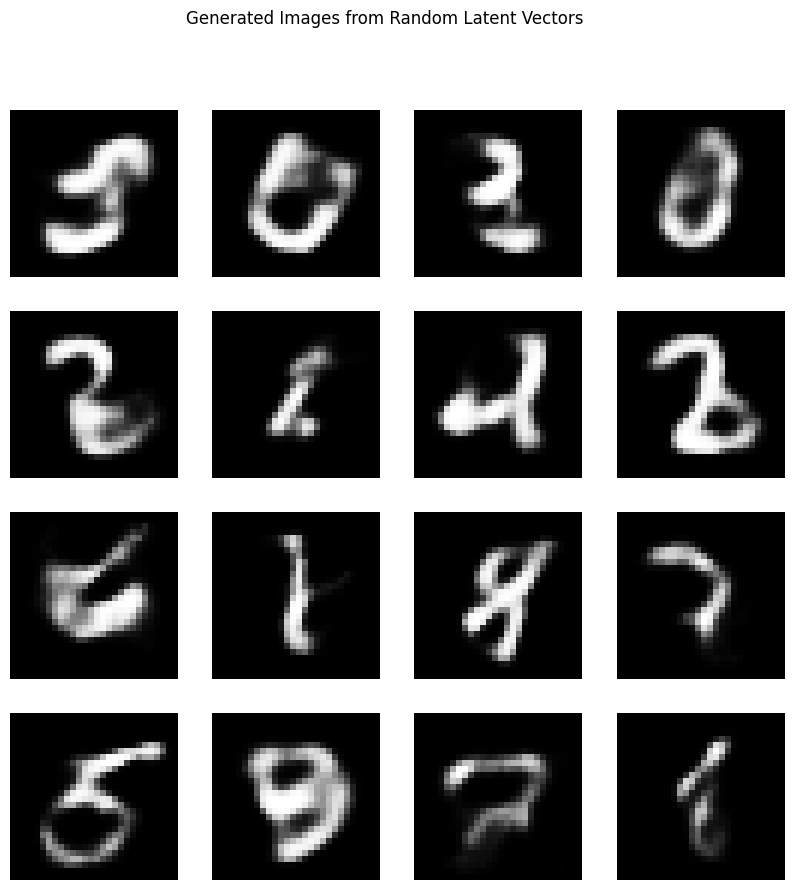

In [5]:
# Generate new images by sampling from the latent space
with torch.no_grad():
    z = torch.randn(16, latent_dim)  # Sample from standard normal distribution
    generated_images = model.decoder(z).view(-1, 1, 28, 28)

# Visualize generated images
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].squeeze(0), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Images from Random Latent Vectors")
plt.show()
